# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
#import tensorflow as tf
from sklearn.metrics import roc_curve, auc



In [3]:
d_type='processed'     # 'processed', 'synthetic'
video_d=True            # Video = True , Image = False 
test_data,number_data_points= False,620

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   
     

# CNN

### GENERATE TRAIN DATA

In [4]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train =  save_trains[0],save_trains[1]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]



In [5]:
if test_data:

    total_data_points=len(y_train)
    test_len=total_data_points-number_data_points
    
    Xx_train=x_train[0:number_data_points]
    Yy_train=y_train[0:number_data_points]

else:

    Xx_train=x_train
    Yy_train=y_train


### check

In [6]:
# X_train,Y_train,X_eval,Y_eval

test_size=0.2
X_train, X_eval, Y_train, Y_eval = train_test_split(Xx_train, Yy_train, test_size=test_size) #,random_state=42)

print('Train data:',len(Y_train),'Evaluation data:',len(Y_eval))
if test_data:print('Test_len:',test_len)

Train data: 583 Evaluation data: 146


 Train data shape: (583, 40, 160, 160, 1)  Validation data shape: (146, 40, 160, 160, 1)


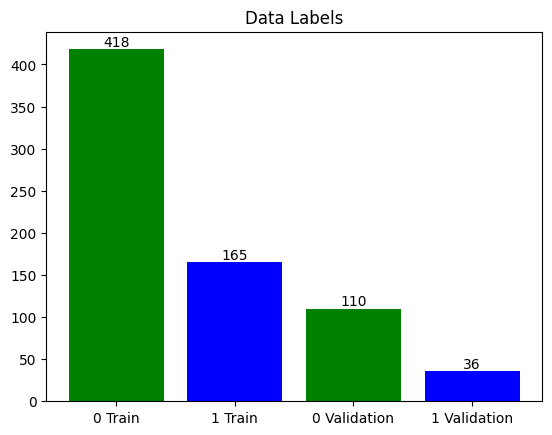

In [7]:
# check data

zeros_count = np.sum(Y_train == 0)
ones_count = np.sum(Y_train == 1)
zeros_count_val = np.sum(Y_eval == 0)
ones_count_val = np.sum(Y_eval == 1)

labels = ['0 Train', '1 Train','0 Validation', '1 Validation']
print(' Train data shape:', np.shape(X_train),' Validation data shape:', np.shape(X_eval))

plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['green', 'blue','green', 'blue'])

for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Data Labels')
plt.show()

### PARAMETERS

In [8]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D


In [9]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epch=7


### MODEL

In [10]:
gc.collect()

3168

In [11]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  model = models.Sequential([
          layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',input_shape=(max_frm_n, HEIGHT, WIDTH, 1)),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=64, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(32, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 158, 158, 32   896       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 19, 79, 79, 32)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 77, 77, 32)    9248      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 9, 38, 38, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 9, 36, 36, 32)     9248      
                                                       

In [12]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

In [13]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)            


### TRAINNING

In [14]:
history =model.fit(X_train, Y_train, epochs=epch, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/7


19/19 [==============================] - ETA: 0s - loss: 1.7683 - accuracy: 0.6364
Epoch 1: val_loss improved from inf to 0.62138, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
19/19 [==============================] - 63s 3s/step - loss: 1.7683 - accuracy: 0.6364 - val_loss: 0.6214 - val_accuracy: 0.7603
Epoch 2/7


c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.6964
Epoch 2: val_loss improved from 0.62138 to 0.62004, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
19/19 [==============================] - 61s 3s/step - loss: 0.6371 - accuracy: 0.6964 - val_loss: 0.6200 - val_accuracy: 0.7534
Epoch 3/7
19/19 [==============================] - ETA: 0s - loss: 0.6170 - accuracy: 0.6964
Epoch 3: val_loss improved from 0.62004 to 0.56200, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
19/19 [==============================] - 62s 3s/step - loss: 0.6170 - accuracy: 0.6964 - val_loss: 0.5620 - val_accuracy: 0.7534
Epoch 4/7
19/19 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7238
Epoch 4: val_loss improved from 0.56200 to 0.53288, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo

### EVALUATE MODEL

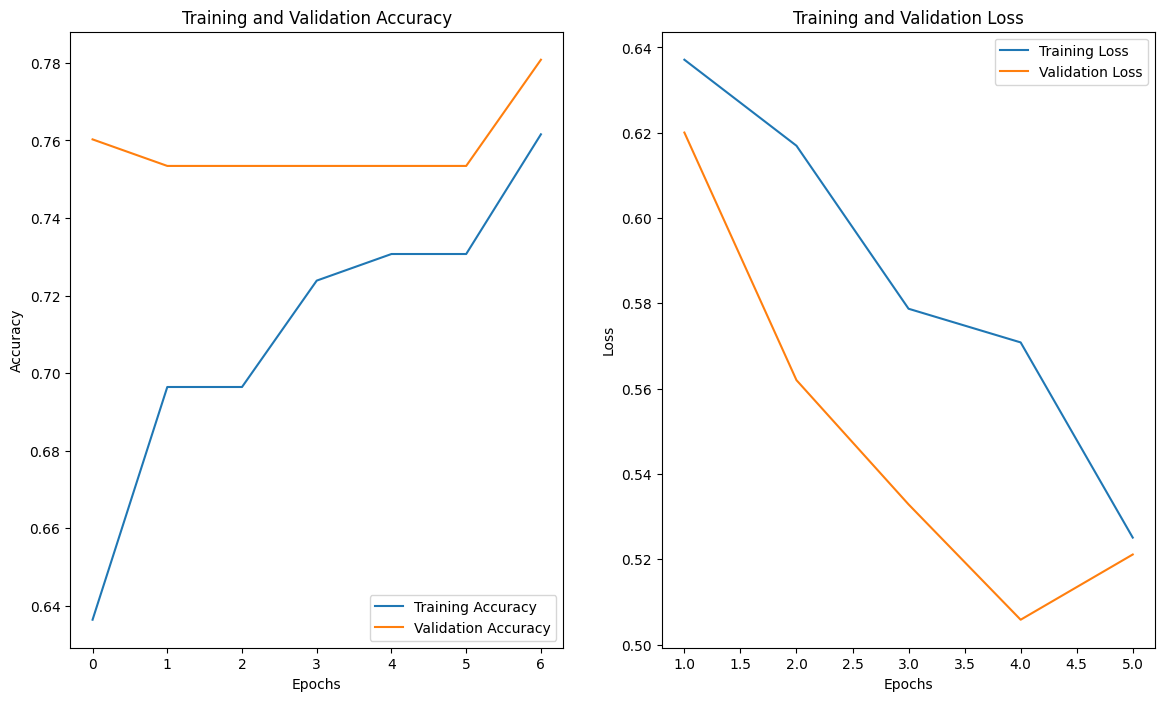

In [15]:
fg_size=(14,8)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epch)

plt.figure(figsize=fg_size)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)
plt.plot(epochs_range[1:-1], loss[1:-1], label='Training Loss')
plt.plot(epochs_range[1:-1], val_loss[1:-1], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

5/5 - 4s - loss: 0.4861 - accuracy: 0.7808 - 4s/epoch - 861ms/step
Loss: 0.48606768250465393 Accuracy: 0.7808219194412231


### BEST EPOCH

In [17]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

5/5 - 4s - loss: 0.4861 - accuracy: 0.7808 - 4s/epoch - 873ms/step
Loss: 0.48606768250465393 Accuracy: 0.7808219194412231


In [18]:
performance_d={'NAME':mdl,
               'ACCURACY':test_accuracy,
               'LOSS':test_loss,
               'VIDEO':video_d,
               'EPOCHS':epch,
               'HEIGHT':HEIGHT,
               'WIDTH':WIDTH}

performance_d

{'NAME': 'video_conv3D',
 'ACCURACY': 0.7808219194412231,
 'LOSS': 0.48606768250465393,
 'VIDEO': True,
 'EPOCHS': 7,
 'HEIGHT': 160,
 'WIDTH': 160}

# ROC CURVE

### VALIDATION DATA

In [19]:
#X_train, X_eval, Y_train, Y_eval 


fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, model.predict(X_eval))


roc_auc_val = auc(fpr_val, tpr_val)

5/5 [==============================] - 4s 807ms/step


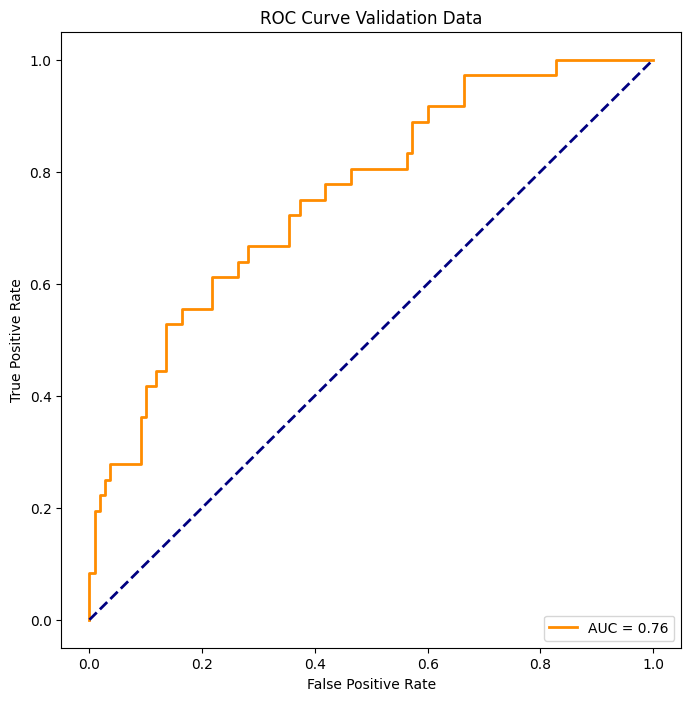

In [20]:
plt.figure(figsize=(8, 8))
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'AUC = {roc_auc_val:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation Data')
plt.legend(loc='lower right')
plt.show()

### TEST DATA

In [21]:
if test_data:
    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_train[number_data_points+1:-1], model.predict(x_train[number_data_points+1:-1]))


    roc_auc = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Testing Data')
    plt.legend(loc='lower right')
    plt.show()